Project Description

Objective: Use the GEDI L2B product to classify the San Pedro Riparian National Conservation Area (SPRNCA) by Foliage Height Diversity (FHD). 

FHD is an important metric for estimating ecological diversity and habitat suitability. Bird species are particularly sensitive in their habitat selection to vertical structure characteristics and the SPRNCA is an internationally recognized habitat zone for migratory and wintering birds. Zones would be classified using unsupervised techniques such as Agglomerative Clustering or DBSCAN. Once regions are classified,  I can evaluate present day trends in water stress over the different FHD classes to evaluate if parts of the corridor that are well suited for sensitive species habitat are particularly susceptible to water stress. To measure water stress, I will use either the ECOSTRESS Evaporative Stress Index (ESI) or EEflux’s METRIC based ET product coupled with ERA5’s PET estimate, depending on data availability. The primary outputs of this project will be maps classifying SPRNCA by FHD and time series plots and maps of the ESI for each FHD class.

The GEDI L2B product has an average spatial footprint of 25 meters and there are ~ 220 observations covering the SPRNCA corridor (I still need to determine how well this time series covers the SPRNCA). So this analysis would be limited to portions of the SPRNCA that have a riparian corridor wider than 25 meters. I also have near daily cloud masks from this area derived from Planet Labs imagery that I will use to filter the L2B and ESI products.

## Notes

GEDI data come in groups, and xarray can only read one at a time.

Quality FAQ with suggestions are here: https://lpdaac.usgs.gov/documents/589/GEDIL02_User_Guide_V1.pdf

conda install pyinterp -c conda-forge possible option for interpolation as it supports unstructured grids, 3D

this tweet has useful info on which beams use full power
https://twitter.com/GEDI_Knights/status/1228203192803966990

- BEAM0000 (ID 0) = Coverage
- BEAM0001 (ID 1) = Coverage
- BEAM0010 (ID 2) = Coverage
- BEAM0011 (ID 3) = Coverage
- BEAM0101 (ID 5) = Power
- BEAM0110 (ID 6) = Power
- BEAM1000 (ID 8) = Power
- BEAM1011 (ID 11) = Power

Interpretation of L2A Quality Flag
In order to provide end users with the ability to easily remove erroneous and/or
lower quality returns, we provide a quality_flag. This is a summation of several
individual quality assessment parameters and is intended to provide general
guidance only. A quality_flag value of 1 indicates the laser shot meets criteria
based on energy, sensitivity, amplitude, and real-time surface tracking quality.
Interpretation of L2B Quality Flag

In order to provide end users with the ability to easily remove erroneous and/or
lower quality returns, and returns not corresponding to the land surface, we
provide a quality_flag based on the outputs of the selected L2A algorithm
settings group. Results are available for every shot with a valid waveform, but
sometimes these results are not directly meaningful, such as vertical profile
metrics over the ocean.

As done for L2A, quality_flag is a summation of several individual quality
assessment parameters and other flags and is intended to provide general
guidance only. A quality_flag value of 1 indicates the cover and vertical profile
metrics represent the land surface and meet criteria based on waveform shot
energy, sensitivity, amplitude, and real-time surface track


In [1]:
#!bash gedi_to_vector.sh # for generating shp files from h5 files

In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pygedi.clean_shps import *
import dask
Path("data/processed/all_samples.gpkg").exists()

shps = list(Path("data/processed").glob("GEDI*.shp"))

if Path("data/processed/all_samples.gpkg").exists() == False:
    gdfs = []
    for path in shps:
        print(path)
        gdf = preprocess_gedi_gdf(path)

        gdfs.append(gdf)

    all_samples_df = pd.concat(gdfs)
    all_samples_df.to_file("data/processed/all_samples.gpkg", driver="GPKG")
else:
    all_samples_df = gpd.read_file("data/processed/all_samples.gpkg", index_col="delta_time")

san_pedro = gpd.read_file("data/site_vectors/OSM_SanPedro.shp")
san_pedro_riparian_corridor = gpd.read_file("data/site_vectors/SPRNCA_bound_wgs84.shp")
fth_wetlands = gpd.read_file("data/site_vectors/FtHua_wetlands.shp")

# the SPRNCA bound file is about 8000m wide but not uniform so this is a uniform buffer at it's widest distance
buffered_river_8000m = san_pedro.to_crs(32612).buffer(8000).to_crs(4326)

all_samples_df.crs = buffered_river_8000m.crs # defines the crs of the GEDI samples as 4326

intersects_riparian_mask = all_samples_df.intersects(buffered_river_8000m.unary_union)

riparian_df = all_samples_df[intersects_riparian_mask]

True

In [76]:
mil_bounds = gpd.read_file("data/site_vectors/hua_military_boundaries.shp")
main_base = mil_bounds.explode()[mil_bounds.explode().area > .03]
watershed = gpd.read_file("data/site_vectors/wbdhu6_spw.shp")
flow_perm = gpd.read_file("data/site_vectors/flow_permanence_SanPedro.shp")
hua_fields = gpd.read_file("data/site_vectors/huachuca_field_polys.shp")

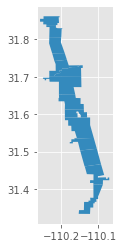

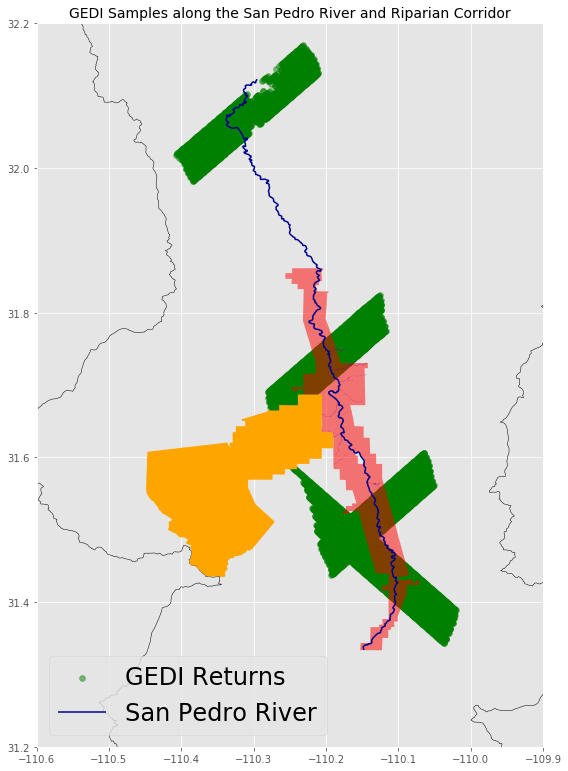

In [122]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8,14))
riparian_df.plot(ax=ax, alpha=.5, color="green", label = "GEDI Returns")
san_pedro.plot(ax=ax, color="darkblue", label = "San Pedro River")
san_pedro_riparian_corridor.plot(ax=ax, color = "red", alpha=.5, label= "SPRNCA Boundary")
fth_wetlands.to_crs(4326).plot(ax=ax, color = "purple", label= "Fort Huachuca Wetlands")
watershed.plot(ax=ax, facecolor="none", edgecolor = "black", label= "Watershed Boundaries")
main_base.plot(ax=ax, color = "orange", label= "Fort Huachuca Boundary")
plt.title("GEDI Samples along the San Pedro River and Riparian Corridor", fontsize = 1)
ax.legend(prop={'size': 24})
ax.set_xlim(-110.6, -109.9)
ax.set_ylim(31.2, 32.2)
plt.tight_layout()
plt.savefig("figs/SPRNCA_and_GEDI.png")

In [ ]:
h5s = list(Path("data/GEDI_L2B_raw/").glob("*.h5"))

In [10]:
beam_groups = ["/BEAM0000", "/BEAM1011", "/BEAM1000", "/BEAM0110", "/BEAM0101", "/BEAM0011", "/BEAM0010", "/BEAM0001"]
beam_sub_groups = ["ancillary", "geolocation", "land_cover_data", "rx_processing"]
meta_group = "METADATA/DatasetIdentification"

In [11]:
def open_beams(file_path, beam_groups = ["/BEAM0000", "/BEAM1011", "/BEAM1000", "/BEAM0110", "/BEAM0101", "/BEAM0011", "/BEAM0010", "/BEAM0001"]):
    datasets = []
    for beam in beam_groups:
        print(beam)
        # coord related values that need to be assigned to the dataset.
        ds_geo = xr.open_dataset(file_path, group=f"/{beam}/geolocation/")
        lat_coords = ds_geo.lat_highestreturn.values
        lon_coords = ds_geo.lon_highestreturn.values
        time_coords = ds_geo.delta_time.values
        
        # renaming and prooer meter units for z, vertical profile
        dz = xr.open_dataset(file_path, group=f"/{beam}/ancillary").dz.values
        ds = xr.open_dataset(file_path, group=beam)
        dim_names = list(ds.dims)
        ds = ds.rename({dim_names[1]:"z"}).drop_dims(dim_names[2]) # phony 6 only used for directional gap prob profile. 
        ds['z'] = ds.z * dz # make z have units in meters
        
        # assigning location and time coords to the variables depending on if they represent avg over profile or are taken along profile
        ds = ds.rename({dim_names[0]:"y"})
        ds['y'] = lat_coords
        ds = ds.assign({"x":lon_coords, "time":time_coords})
        
        datasets.append(ds)
    return datasets

In [13]:
file_paths = list(Path("data").glob("*.h5"))

In [54]:
len(xr.open_dataset(file_paths[14], group="/BEAM1011/geolocation").coords['delta_time'].values)

410254

In [ ]:
list(xr.open_dataset(file_paths[0], group="/BEAM1011").dims)

In [ ]:
open_beams(file_paths[0])

In [36]:
shps[0]

PosixPath('data/GEDI02_B_2019125153619_O02233_T05438_02_001_01.shp')

In [51]:
file_paths[14]

PosixPath('data/GEDI02_B_2019125153619_O02233_T05438_02_001_01.h5')

In [ ]:
test_beam.sensitivity
test_beam.fhd_normal
test_beam.l2a_quality_flag
test_beam.l2b_quality_flag
test_beam.pai
test_beam.pai_z
test_beam.pavd_z
test_beam.l2b_quality_flag

In [ ]:
ds = xr.Dataset({'pai_z': (['x', 'y', 'time', 'z'],  test_beam.pai_z),
                 coords={'x': (['x', 'y'], lon_coords),
                         'y': (['x', 'y'], lat_coords),
                         'time': time_coords,
                        "z": test_beam.phony_dim_5.values}})